In [2]:
import torch
from pathlib import Path

img = torch.load(
    "/lustre/fswork/projects/rech/krk/commun/datasets/IXI/caps_IXI" \
    "/subjects/sub-IXI148/ses-M000/deeplearning_prepare_data/slice_based/t1_linear"  \
    "/sub-IXI148_ses-m000_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w_slice-axial_100.pt"
)

print(img.shape)
print(img.min())
print(img.max())

torch.Size([193, 229])
tensor(-1.)
tensor(0.6372)


## Initialize experiments

In [ ]:
# Create experiment folder

# Unet config
# Diffusion config
# Training config

## Load Dataset 

In [1]:
from image_datasets.capsSlicesIXI import CapsSlicesIXI
from image_datasets.transforms import ClipTensor
from torchvision import transforms
from pathlib import Path

caps_dir = Path("/lustre/fswork/projects/rech/krk/commun/datasets/IXI/caps_IXI")
train_tsv = caps_dir / "IXI_train.tsv"
val_tsv = caps_dir / "IXI_validation.tsv"

transform=transforms.Compose([
    transforms.Pad([0, 18], fill=0),
    ClipTensor(),
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda t: 2 * (t-t.min())/(t.max()-t.min()) - 1),    # Image range between [-1, 1]
])

train_set = CapsSlicesIXI(caps_dir, train_tsv, transform)
val_set = CapsSlicesIXI(caps_dir, val_tsv, transform)

channels, image_length, image_width  = train_set[0]['T1'].shape
print(f"Train set size: {len(train_set)}.")
print(f"Validation set size: {len(val_set)}.")
print(f"Image of size {image_length}x{image_width}, with {channels} channel(s).")
print(f"Min voxel value = {train_set[0]['T1'].min()}, Max voxel value = {train_set[0]['T1'].max()}.")
image_size = image_length

Train set size: 15000.
Validation set size: 1110.
Image of size 64x64, with 1 channel(s).
Min voxel value = -1.0, Max voxel value = 1.0.


In [2]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    prefetch_factor=2,
    drop_last=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    drop_last=True,
)

## Initialize denoising model

In [3]:
import torch 
from model.unet import Unet
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 2,),
    n_block_klass = 2,
)
UnetConfig = UnetConfig(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 2,),
    n_block_klass = 2,
)

model = Unet(
    **UnetConfig.model_dump()
)
model.to(device)

print(f"Working on {device}.")
summary(model)

Working on cuda.


Layer (type:depth-idx)                                       Param #
Unet                                                         --
├─Conv2d: 1-1                                                128
├─Sequential: 1-2                                            --
│    └─SinusoidalPositionEmbeddings: 2-1                     --
│    └─Linear: 2-2                                           16,640
│    └─GELU: 2-3                                             --
│    └─Linear: 2-4                                           65,792
├─ModuleList: 1-3                                            --
│    └─ModuleList: 2-5                                       --
│    │    └─ResnetBlock: 3-1                                 107,008
│    │    └─ResnetBlock: 3-2                                 107,008
│    │    └─Residual: 3-3                                    33,088
│    │    └─Sequential: 3-4                                  16,448
│    └─ModuleList: 2-6                                       --
│    │  

## Initialize diffusion class

In [4]:
from diffusion.time_scheduler import quadratic_beta_schedule
from diffusion.diffusion import DiffusionModel

timesteps = 1000
betas = quadratic_beta_schedule(timesteps, beta_start=0.00001, beta_end=0.01)
loss_type = 'huber'

ddpm = DiffusionModel(model, timesteps, betas, device, loss_type=loss_type)

## Train the model

In [5]:
from torch.optim import Adam

epochs = 10
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

ddpm.train(epochs, optimizer, train_loader, val_loader, scheduler=scheduler)

# Save Unet
torch.save(model.state_dict(), "results/unet.pt")

Epoch 0: 100%|##########| 234/234 [00:51<00:00,  4.50it/s]


Train Loss: 0.2233972117368482
Val Loss: 0.05941525233142516


Epoch 1: 100%|##########| 234/234 [00:50<00:00,  4.61it/s]


Train Loss: 0.11224476563242766
Val Loss: 0.04529793275629773


Epoch 2: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.09418925270438194
Val Loss: 0.044387209941359126


Epoch 3: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.08592497081392342
Val Loss: 0.033750549342264145


Epoch 4: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.08017837396289548
Val Loss: 0.036336336613577956


Epoch 5: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.07879749028028077
Val Loss: 0.03596609403543612


Epoch 6: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.0765648966607375
Val Loss: 0.037742145907352954


Epoch 7: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.07459887833549426
Val Loss: 0.03658417656141169


Epoch 8: 100%|##########| 234/234 [00:50<00:00,  4.59it/s]


Train Loss: 0.07323549531845965
Val Loss: 0.03410741894998971


Epoch 9: 100%|##########| 234/234 [00:50<00:00,  4.60it/s]


Train Loss: 0.07270220146538356
Val Loss: 0.03628660124890944
End of training!


## Check overfitting

In [12]:
psnr_in_train, psnr_out_train = ddpm.compute_psnr(train_loader, psnr_step=50)
psnr_in_val, psnr_out_val = ddpm.compute_psnr(val_loader, psnr_step=50)

100%|##########| 20/20 [00:52<00:00,  2.64s/it]


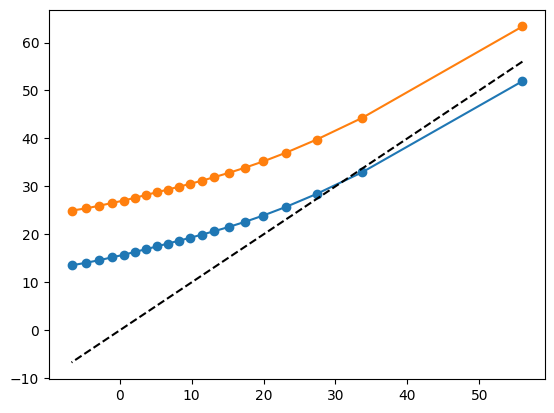

In [15]:
import matplotlib.pyplot as plt
plt.plot(psnr_in_train, psnr_out_train, marker='o')
plt.plot(psnr_in_train, psnr_in_train, linestyle='--', c='k')
plt.plot(psnr_in_val, psnr_out_val, marker='o')
plt.show()

## Sample

In [10]:
model = model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 2,),
    n_block_klass = 2,
)
model.load_state_dict(torch.load("results/unet.pt", weights_only=True))
model.to(device)
model.eval()
ddpm = DiffusionModel(model, timesteps, betas, device, loss_type='huber')

1000


sampling loop time step: 100%|##########| 1000/1000 [01:08<00:00, 14.51it/s]


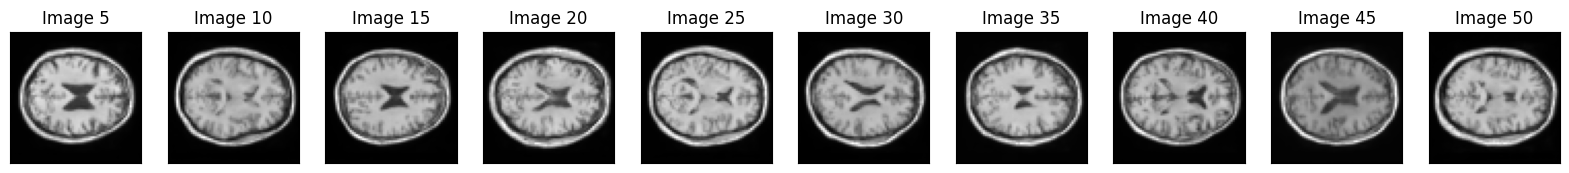

In [11]:
from diffusion.sampler import sample
import matplotlib.pyplot as plt

# sample 64 images
samples = sample(ddpm, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_indexes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axs = plt.subplots(1, 10, figsize=(20, 8))
for i in range(10):
    idx = random_indexes[i]
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f"Image {idx}")
    axs[i].imshow(samples[-1][idx].reshape(image_size, image_size, channels), cmap="gray")
plt.show()

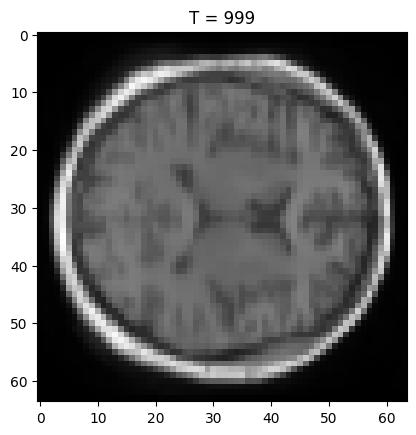

In [12]:
import matplotlib.animation as animation

random_index = 5

fig = plt.figure()
ims = []
for i in range(timesteps):
    plt.title(f"T = {i}")
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion64x64.gif')
plt.show()